# Load Dependencies 

This leverages the __`tf.keras`__ API style and hence it is recommended you try this out on TensorFlow 2.x

In [ ]:
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print(tf.__version__)

# Main Objective — Building an Apparel Classifier & Perform Adversarial Learning 

- We will keep things simple here with regard to the key objective. We will build a simple apparel classifier by training models on the very famous [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset based on Zalando’s article images — consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. The idea is to classify these images into an apparel category amongst 10 categories on which we will be training our models on.

- The second main objective here is to perturb and add some intentional noise to these apparel images to try and fool our classification model.

Here's an example how the data looks (each class takes three-rows):

<table>
  <tr><td>
    <img src="https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. You can access the Fashion MNIST directly from TensorFlow.

__Note:__ Although these are really images, they are loaded as NumPy arrays and not binary image objects.

We will train a CNN (Convolutional Neural Network) classifiers in this notebook - 
- CNN trained on the regular training set images of FashionMNIST

# Load Dataset
Here we will leverage an out of the box dataset to keep things simple as we mentioned earlier by leveraging the Fashion-MNIST dataset.

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


Train_images.shape: (60000, 28, 28), of uint8
Test_images.shape: (10000, 28, 28), of uint8


# Training a Shallow CNN on the FashionMNIST dataset

In this phase, we will __not__ be using any adversarial perturbations. 

## Reshaping Image Data for Modeling

We need to add a channel dimension to our dataset otherwise convolution layers won't work. We also scale the pixel values to [0, 1] range. 

In [ ]:
train_images = np.expand_dims(train_images, -1) / 255.
test_images = np.expand_dims(test_images, -1) / 255.

## View Sample Data

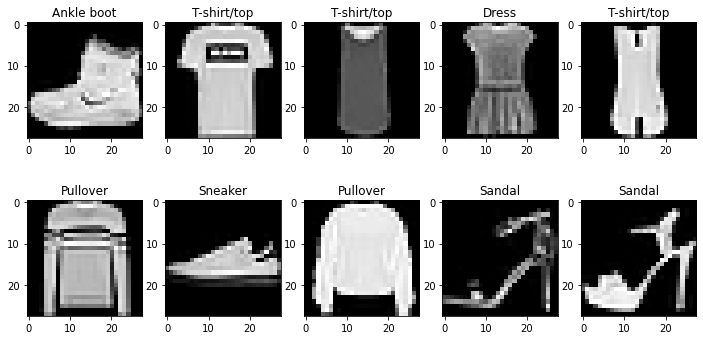

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
c = 0
for i in range(10):
    idx = i // 5
    idy = i % 5 
    ax[idx, idy].imshow(train_images[i].squeeze(), cmap="gray")
    ax[idx, idy].set_title(class_names[train_labels[i]])

## Model Utils

In [ ]:
# define input shape
INPUT_SHAPE = (28, 28, 1)

def get_training_model(main_activation='relu'):
    inputs = tf.keras.Input(shape=INPUT_SHAPE)
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding="same", activation=main_activation)(inputs)
    x = tf.keras.layers.MaxPool2D((2,2))(x)
    x = tf.keras.layers.Conv2D(62, (3, 3), strides=2, padding="same", activation=main_activation)(x)
    x = tf.keras.layers.MaxPool2D((2,2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256)(x)
    outputs = tf.keras.layers.Dense(10)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

get_training_model().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 62)          17918     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 62)          0         
_________________________________________________________________
flatten (Flatten)            (None, 248)               0         
_________________________________________________________________
dense (Dense)                (None, 256)              

In [ ]:
def plot_progress(hist):
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="validation_loss")
    plt.plot(hist.history["accuracy"], label="training_accuracy")
    plt.plot(hist.history["val_accuracy"], label="validation_accuracy")
    plt.title("Training Progress")
    plt.ylabel("accuracy/loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.show()

## Optimizer, Loss, and TensorFlow Dataset

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

regular_model = get_training_model()
regular_model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])

BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels)
).shuffle(buffer_size=4096).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_images, test_labels)
).batch(BATCH_SIZE)

## Model Training

Epoch 1/10
938/938 [==============================] - 3s 3ms/step - loss: 0.5556 - accuracy: 0.7993 - val_loss: 0.4227 - val_accuracy: 0.8495
Epoch 2/10
938/938 [==============================] - 4s 5ms/step - loss: 0.3663 - accuracy: 0.8694 - val_loss: 0.3636 - val_accuracy: 0.8675
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.3208 - accuracy: 0.8846 - val_loss: 0.3506 - val_accuracy: 0.8716
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 0.2935 - accuracy: 0.8949 - val_loss: 0.3357 - val_accuracy: 0.8801
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 0.2767 - accuracy: 0.9004 - val_loss: 0.3114 - val_accuracy: 0.8909
Epoch 6/10
938/938 [==============================] - 4s 4ms/step - loss: 0.2614 - accuracy: 0.9044 - val_loss: 0.3089 - val_accuracy: 0.8926
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.2501 - accuracy: 0.9093 - val_loss: 0.3015 - val_accuracy: 0.8950
Epoch 

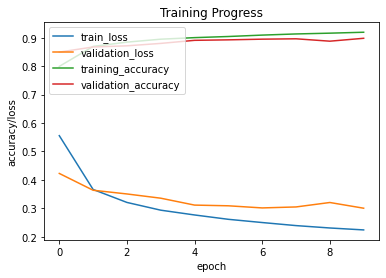

In [ ]:
history = regular_model.fit(train_dataset, 
                            validation_data=test_dataset, 
                            epochs=10)
plot_progress(history)

## Evaluate Model Performance on Test Data

In [ ]:
predictions = regular_model.predict(test_images)
predictions = tf.nn.softmax(predictions)
prediction_labels = np.argmax(predictions, axis=1)
print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.86      0.85      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.82      0.88      0.85      1000
       Dress       0.91      0.87      0.89      1000
        Coat       0.85      0.82      0.83      1000
      Sandal       0.97      0.97      0.97      1000
       Shirt       0.73      0.72      0.72      1000
     Sneaker       0.97      0.92      0.95      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.94      0.98      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,862,0,16,15,3,0,96,0,8,0
Trouser,2,975,1,14,3,0,3,0,2,0
Pullover,12,1,884,10,40,0,53,0,0,0
Dress,30,4,14,871,35,0,46,0,0,0
Coat,0,2,85,25,821,0,67,0,0,0
Sandal,0,0,0,0,0,972,0,9,1,18
Shirt,120,0,74,19,63,0,717,0,7,0
Sneaker,0,0,0,0,0,28,0,924,0,48
Bag,2,1,2,3,6,2,5,2,976,1
Ankle boot,1,0,0,0,0,4,0,16,0,979


# Adversarial Attacks with Fast Gradient Sign Method (FGSM)

## What is an adversarial example?

Adversarial examples are specialised inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. These notorious inputs are indistinguishable to the human eye, but cause the network to fail to identify the contents of the image. There are several types of such attacks, however, here the focus is on the fast gradient sign method attack, which is a *white box* attack whose goal is to ensure misclassification. A white box attack is where the attacker has complete access to the model being attacked. One of the most famous examples of an adversarial image shown below is taken from the aforementioned paper.

![Adversarial Example](https://i.imgur.com/FyYq2Q0.png)

Here, starting with the image of a panda, the attacker adds small perturbations (distortions) to the original image, which results in the model labelling this image as a gibbon, with high confidence. The process of adding these perturbations is explained below.

## Fast gradient sign method

The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:
$$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

where 

*   adv_x : Adversarial image.
*   x : Original input image.
*   y : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

An intriguing property here, is the fact that the gradients are taken with respect to the input image. This is done because the objective is to create an image that maximises the loss. 

A method to accomplish this is to find how much each pixel in the image contributes to the loss value, and add a perturbation accordingly. 

This works pretty fast because it is easy to find how each input pixel contributes to the loss by using the chain rule and finding the required gradients. 

Hence, the gradients are taken with respect to the image. In addition, since the model is no longer being trained (thus the gradient is not taken with respect to the trainable variables, i.e., the model parameters), and so the model parameters remain constant. The only goal is to fool an already trained model.

So let's try and fool our pretrained VGG19 model.

## Utility Functions for FGSM

1. __`get_model_preds(...)`__: Helps in getting the top predicted class label and probability of an input image based on a specific trained CNN model

2. __`generate_adverarial_pattern(...)`__: Helps in getting the gradients and the sign of the gradients w.r.t the input image and the trained CNN model

3. __`perform_adversarial_attack_fgsm(...)`__: Create perturbations which will be used to distort the original image resulting in an adversarial image by adding epsilon to the gradient signs (can be added to gradients also) and then showcase model performance on the same

In [ ]:
def get_model_preds(input_image, class_names_map, model):
        logits = model.predict(input_image)
        preds = tf.nn.softmax(logits)
        top_idx = np.argsort(-preds)[0][0]
        top_prob = -np.sort(-preds)[0][0]
        top_class = np.array(class_names_map)[top_idx]
        return top_class, top_prob


def generate_adverarial_pattern(input_image, image_label_idx, model, loss_func):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        #prediction = tf.nn.softmax(prediction)
        loss = loss_func(image_label_idx, prediction)
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad


def perform_adversarial_attack_fgsm(input_image, image_label_idx, cnn_model, class_names_map, loss_func, eps=0.01):
    # basic image shaping
    input_image = np.array([input_image])
    tf_img = tf.convert_to_tensor(input_image)
    # predict class before adversarial attack
    ba_pred_class, ba_pred_prob = get_model_preds(tf_img, class_names_map, cnn_model)
    # generate adversarial image
    adv_pattern = generate_adverarial_pattern(tf_img, image_label_idx, cnn_model, loss_func)
    clip_adv_pattern = tf.clip_by_value(adv_pattern, clip_value_min=0., clip_value_max=1.)

    perturbed_img = tf_img + (eps * clip_adv_pattern)
    perturbed_img = tf.clip_by_value(perturbed_img, clip_value_min=0., clip_value_max=1.)
    # predict class after adversarial attack
    aa_pred_class, aa_pred_prob = get_model_preds(perturbed_img, class_names_map, cnn_model)
    
    # visualize results
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    ax[0].imshow(tf_img[0].numpy().squeeze(), cmap='gray')
    ax[0].set_title('Before Adversarial Attack\nTrue:{}  Pred:{}  Prob:{:.3f}'.format(class_names_map[image_label_idx],
                                                                                      ba_pred_class,
                                                                                      round(ba_pred_prob, 3)))
    
    ax[1].imshow(clip_adv_pattern[0].numpy().squeeze(), cmap='gray')
    ax[1].set_title('Adverarial Pattern -  EPS:{}'.format(eps))
    
    ax[2].imshow(perturbed_img[0].numpy().squeeze(), cmap='gray')
    ax[2].set_title('After Adversarial Attack\nTrue:{}  Pred:{}  Prob:{:.3f}'.format(class_names_map[image_label_idx],
                                                                                     aa_pred_class,
                                                                                     aa_pred_prob))
    


## Adversarial Attack Examples

In [ ]:
# We want maximize the cross-entropy loss
scc = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

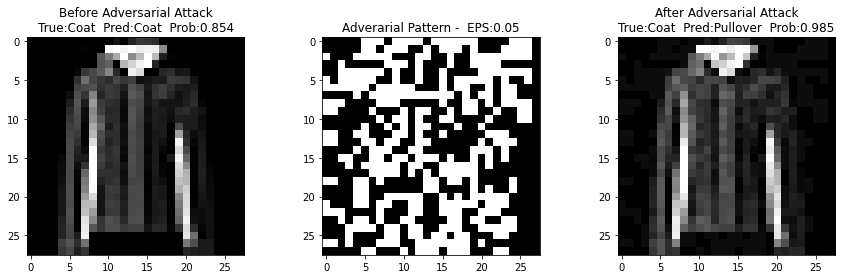

In [ ]:
sample_apparel_idx = 6
sample_apparel_img =  test_images[sample_apparel_idx]
sample_apparel_labelidx = test_labels[sample_apparel_idx]
perform_adversarial_attack_fgsm(input_image=sample_apparel_img, 
                                image_label_idx=sample_apparel_labelidx, 
                                cnn_model=regular_model, class_names_map=class_names,
                                loss_func=scc, eps=0.05)

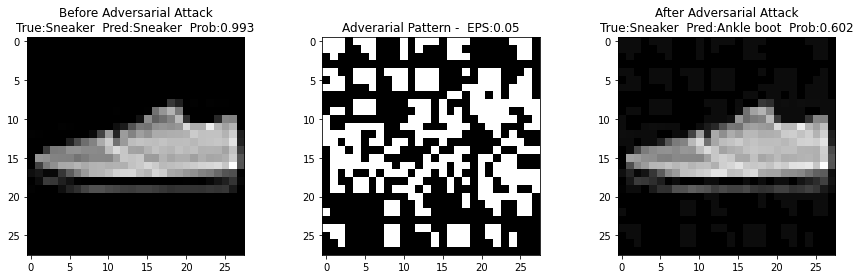

In [ ]:
sample_apparel_idx = 60
sample_apparel_img =  test_images[sample_apparel_idx]
sample_apparel_labelidx = test_labels[sample_apparel_idx]
perform_adversarial_attack_fgsm(input_image=sample_apparel_img, 
                                image_label_idx=sample_apparel_labelidx, 
                                cnn_model=regular_model, class_names_map=class_names,
                                loss_func=scc, eps=0.05)

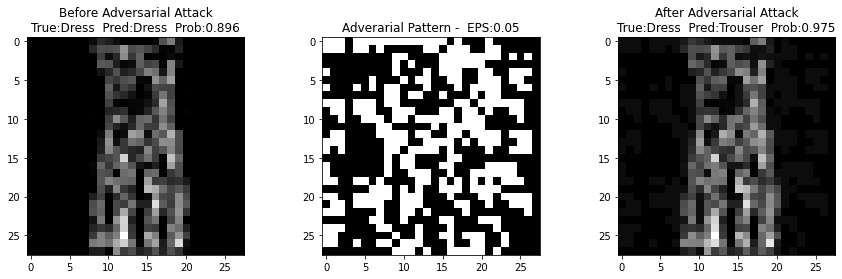

In [ ]:
sample_apparel_idx = 560
sample_apparel_img =  test_images[sample_apparel_idx]
sample_apparel_labelidx = test_labels[sample_apparel_idx]
perform_adversarial_attack_fgsm(input_image=sample_apparel_img, 
                                image_label_idx=sample_apparel_labelidx, 
                                cnn_model=regular_model, class_names_map=class_names,
                                loss_func=scc, eps=0.05)

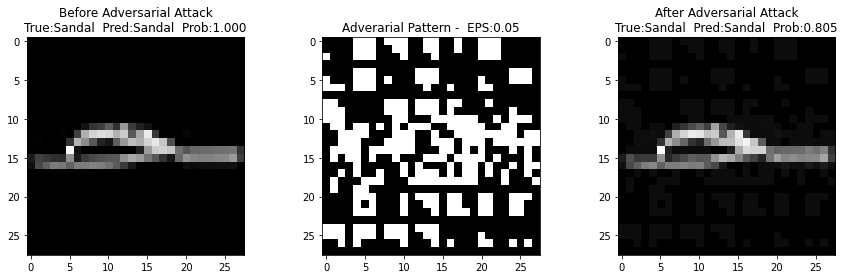

In [ ]:
sample_apparel_idx = 8
sample_apparel_img =  test_images[sample_apparel_idx]
sample_apparel_labelidx = test_labels[sample_apparel_idx]
perform_adversarial_attack_fgsm(input_image=sample_apparel_img, 
                                image_label_idx=sample_apparel_labelidx, 
                                cnn_model=regular_model, class_names_map=class_names,
                                loss_func=scc, eps=0.05)

## Generate Adversarial Attacks (FGSM) on Test Data to create Perturbed Test Dataset

In [ ]:
def generate_perturbed_images(input_images, image_label_idxs, model, loss_func, eps=0.01):
  perturbed_images = []
  # don't use list on large data - used just to view fancy progress-bar
  for image, label in tqdm(list(zip(input_images, image_label_idxs))): 
      image = tf.convert_to_tensor(np.array([image]))
      adv_pattern = generate_adverarial_pattern(image, label, model, loss_func)
      clip_adv_pattern = tf.clip_by_value(adv_pattern, clip_value_min=0., clip_value_max=1.)
      perturbed_img = image + (eps * clip_adv_pattern)
      perturbed_img = tf.clip_by_value(perturbed_img, clip_value_min=0., clip_value_max=1.)[0]
      perturbed_images.append(perturbed_img)

  return tf.convert_to_tensor(perturbed_images)

In [ ]:
perturbed_test_imgs = generate_perturbed_images(input_images=test_images, 
                                                image_label_idxs=test_labels, model=regular_model, 
                                                loss_func=scc, eps=0.05)

100%|██████████| 10000/10000 [01:04<00:00, 154.90it/s]


In [ ]:
predictions = regular_model.predict(perturbed_test_imgs)
predictions = tf.nn.softmax(predictions)
prediction_labels = np.argmax(predictions, axis=1)
print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.26      0.21      0.23      1000
     Trouser       0.90      0.90      0.90      1000
    Pullover       0.16      0.14      0.15      1000
       Dress       0.52      0.29      0.37      1000
        Coat       0.13      0.12      0.13      1000
      Sandal       0.61      0.50      0.55      1000
       Shirt       0.03      0.05      0.03      1000
     Sneaker       0.42      0.26      0.32      1000
         Bag       0.77      0.73      0.75      1000
  Ankle boot       0.55      0.78      0.64      1000

    accuracy                           0.40     10000
   macro avg       0.43      0.40      0.41     10000
weighted avg       0.43      0.40      0.41     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,214,3,48,51,9,1,658,0,15,1
Trouser,11,902,6,53,9,0,15,0,4,0
Pullover,14,5,142,12,278,0,544,0,5,0
Dress,248,68,32,291,145,0,208,0,8,0
Coat,5,14,388,87,122,1,380,0,3,0
Sandal,1,4,0,0,0,502,4,175,129,185
Shirt,306,4,258,34,326,0,49,0,22,1
Sneaker,0,0,0,0,0,263,0,259,30,448
Bag,36,3,29,31,46,23,94,4,731,3
Ankle boot,1,0,0,0,0,34,0,181,8,776


The performance (validation accuracy) of our shallow CNN model gets down to 40%. So, this begs the following the question - 

> *Can't we just train a model on an adversarially perturbed dataset?* 

This is what we are gonna do next in [this notebook](https://github.com/dipanjanS/adversarial-learning-robustness/blob/main/tutorials/adversarial_training/01_1_adv_training_scratch.ipynb). 